In [498]:
import pandas as pd
import numpy as np

filepath = '/home/justus/ml-exploration/pytorch-explore/AAPL model v1/AAPL.csv'

df = pd.read_csv(filepath)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')


df.head()

,Date,Close,Volume,Open,High,Low
2514,2012-08-17,23.1468,441829183,22.8572,23.1497,22.8147
2513,2012-08-20,23.7554,611969715,23.2147,23.7554,23.2107
2512,2012-08-21,23.4308,811169756,23.9579,24.1029,23.2261
2511,2012-08-22,23.8882,563600295,23.3722,23.8929,23.1468
2510,2012-08-23,23.6654,419420792,23.7897,23.9250,23.6125


<AxesSubplot:xlabel='Date'>

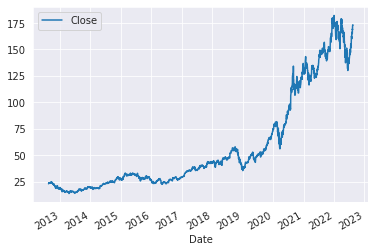

In [499]:
import matplotlib.pyplot as plt
import seaborn as sns

df.plot(kind='line', x='Date', y='Close')


In [500]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price= df[['Close']]
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

price.head()

/tmp/ipykernel_21045/852040389.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Close
2514,-0.890525
2513,-0.883283
2512,-0.887146
2511,-0.881702
2510,-0.884354


In [501]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []

    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]



In [502]:
from sklearn.model_selection import train_test_split

def split_data_2(stock, lookback):
    data_raw = stock.to_numpy()
    data = []

    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)

    x_train, x_test, y_train, y_test = train_test_split(data[:,:-1], data[:,-1], test_size=0.2)

    return [x_train, y_train, x_test, y_test]


In [503]:
lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

print(x_train)

x_train.shape =  (1996, 19, 1)
y_train.shape =  (1996, 1)
x_test.shape =  (499, 19, 1)
y_test.shape =  (499, 1)
[[[-0.89052525]
  [-0.88328271]
  [-0.88714556]
  ...
  [-0.88522127]
  [-0.88131082]
  [-0.87570457]]

 [[-0.88328271]
  [-0.88714556]
  [-0.88170234]
  ...
  [-0.88131082]
  [-0.87570457]
  [-0.87217731]]

 [[-0.88714556]
  [-0.88170234]
  [-0.88435374]
  ...
  [-0.87570457]
  [-0.87217731]
  [-0.86856437]]

 ...

 [[-0.00840461]
  [-0.06109334]
  [-0.06383042]
  ...
  [ 0.20267758]
  [ 0.20145779]
  [ 0.19788769]]

 [[-0.06109334]
  [-0.06383042]
  [-0.03770919]
  ...
  [ 0.20145779]
  [ 0.19788769]
  [ 0.20925251]]

 [[-0.06383042]
  [-0.03770919]
  [-0.05624396]
  ...
  [ 0.19788769]
  [ 0.20925251]
  [ 0.21097806]]]


In [504]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)


In [505]:
input_dim = 1
hidden_dim = 32
num_layers = 3
output_dim = 1
num_epochs = 2000

In [506]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device="cuda").requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [507]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)

In [508]:
torch.cuda.set_device(0)

x_train = x_train.cuda()
x_test = x_test.cuda()
y_train_gru = y_train_gru.cuda()
y_test_gru = y_test_gru.cuda()
model = model.cuda()

In [509]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch 0 MSE:  0.33063143491744995
Epoch 1 MSE:  0.32602596282958984
Epoch 2 MSE:  0.3216068744659424
Epoch 3 MSE:  0.31724655628204346
Epoch 4 MSE:  0.31290125846862793
Epoch 5 MSE:  0.308551549911499
Epoch 6 MSE:  0.30418774485588074
Epoch 7 MSE:  0.2998049259185791
Epoch 8 MSE:  0.29540055990219116
Epoch 9 MSE:  0.29097363352775574
Epoch 10 MSE:  0.2865241467952728
Epoch 11 MSE:  0.282052606344223
Epoch 12 MSE:  0.27756014466285706
Epoch 13 MSE:  0.27304807305336
Epoch 14 MSE:  0.2685180902481079
Epoch 15 MSE:  0.26397189497947693
Epoch 16 MSE:  0.25941145420074463
Epoch 17 MSE:  0.25483882427215576
Epoch 18 MSE:  0.2502559423446655
Epoch 19 MSE:  0.245665043592453
Epoch 20 MSE:  0.24106810986995697
Epoch 21 MSE:  0.23646722733974457
Epoch 22 MSE:  0.23186445236206055
Epoch 23 MSE:  0.22726181149482727
Epoch 24 MSE:  0.22266145050525665
Epoch 25 MSE:  0.21806550025939941
Epoch 26 MSE:  0.2134762406349182
Epoch 27 MSE:  0.20889602601528168
Epoch 28 MSE:  0.20432713627815247
Epoch 29 M

In [510]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().cpu().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().cpu().numpy()))

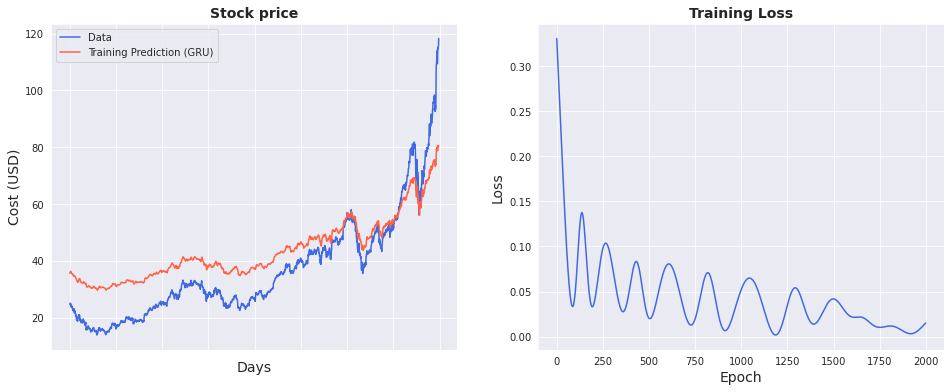

In [511]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [512]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().cpu().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 10.30 RMSE
Test Score: 59.38 RMSE


In [513]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [514]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()